## 1. Import Library


In [17]:
!pip install mplfinance
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


## 2.Load dataset

Mengambil data historis dari yahoo finance karena menggunakan library yfinance dengan arg max artinya sebanyak mungkin data yang ada dan menampilkan 5 baris data terakhir

In [18]:
df = yf.Ticker("BBNI.JK")
df = df.history(period="max")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-12-23 00:00:00+07:00,319.488708,344.064753,319.488708,319.488708,853373,0.0,0.0
2003-12-24 00:00:00+07:00,319.488708,319.488708,319.488708,319.488708,0,0.0,0.0
2003-12-25 00:00:00+07:00,319.488708,319.488708,319.488708,319.488708,0,0.0,0.0
2003-12-26 00:00:00+07:00,319.488708,319.488708,319.488708,319.488708,0,0.0,0.0
2003-12-29 00:00:00+07:00,319.488662,337.920685,319.488662,337.920685,319619,0.0,0.0


Menghapus kolom dividens dan stocksplits

In [19]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)


memvisualisasikan data saham BBNI dalam bentuk candlestick chart menggunakan library mplfinance

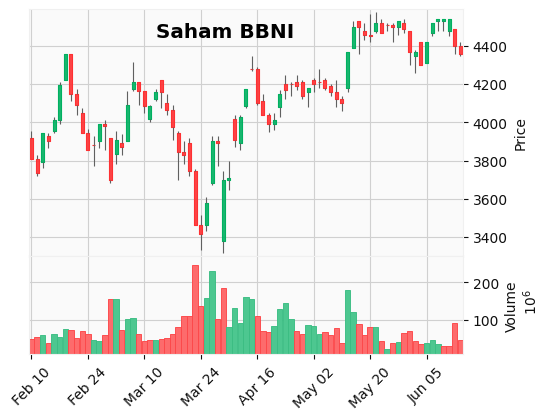

<function matplotlib.pyplot.show(close=None, block=None)>

In [20]:
dfVisual = df.loc["2025-02-9":].copy()

mpf.plot(dfVisual, type='candle', style='yahoo', title='Saham BBNI',
         ylabel='Price', ylabel_lower='Volume', figsize=(5,4),
         volume=True, tight_layout=True)

mpf.show


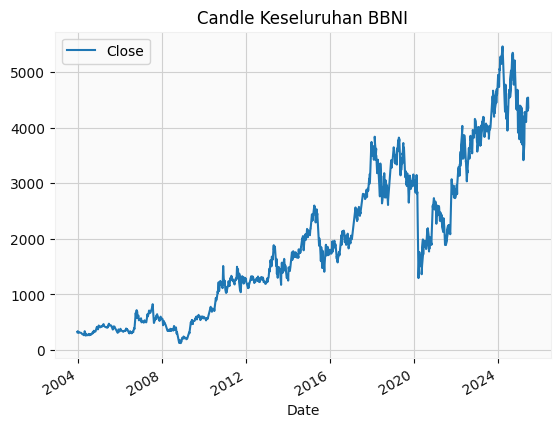

In [21]:
df.plot.line(y="Close", use_index=True)
plt.title("Candle Keseluruhan BBNI")
plt.show()

mengambil dataframe dari tanggal 1-1-2020 dan seterusnya

In [22]:
df = df.loc["2020-01-01":].copy()

In [23]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-11 00:00:00+07:00,4530.0,4540.0,4480.0,4540.0,35008700
2025-06-12 00:00:00+07:00,4530.0,4540.0,4480.0,4540.0,29571100
2025-06-13 00:00:00+07:00,4480.0,4540.0,4450.0,4540.0,30548300
2025-06-16 00:00:00+07:00,4490.0,4490.0,4360.0,4400.0,90223800
2025-06-17 00:00:00+07:00,4400.0,4420.0,4350.0,4360.0,44876400


In [24]:
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")


Jumlah baris: 1312
Jumlah kolom: 5


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1312 entries, 2020-01-02 00:00:00+07:00 to 2025-06-17 00:00:00+07:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1312 non-null   float64
 1   High    1312 non-null   float64
 2   Low     1312 non-null   float64
 3   Close   1312 non-null   float64
 4   Volume  1312 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 61.5 KB


mengambil data harga penutupan dari DataFrame, mengubahnya menjadi array NumPy, dan kemudian membentuk kembali (reshape) array tersebut menjadi array 2D dengan satu kolom.

In [26]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [27]:
# Memuat data
prices = df['Close'].values.reshape(-1, 1)

In [28]:
prices

array([[3087.43188477],
       [3097.35986328],
       [3027.86743164],
       ...,
       [4540.        ],
       [4400.        ],
       [4360.        ]])

In [29]:
prices.shape

(1312, 1)

## 3.Preprocessing data

In [30]:
# Menormalkan data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Membagi data menjadi data latih dan data uji
train_size = int(len(scaled_prices) * 0.8)
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]

mengatur data ke dalam format yang sesuai untuk model machine learning dengan menggunakan konsep lookback untuk membuat fitur dari data historis

In [31]:
# Membuat dataset latih dan uji
def create_dataset(data, lookback):
    X, Y = [], []
    for i in range(len(data) - lookback):
      X.append(data[i:i+lookback])
      Y.append(data[i+lookback])
    return np.array(X), np.array(Y)

lookback = 10
X_train, Y_train = create_dataset(train_data, lookback)
test_X, test_Y = create_dataset(test_data, lookback)


## 4. Build model

In [32]:
# Membangun model lstm

model = Sequential([
    LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(lookback, 1)),
    LSTM(50, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(25),
    Dense(1)
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
# train model
model.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - loss: 0.0886
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0332
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0325
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0320
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0292
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0284
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0227
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0237
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0195
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0162
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0139
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0117
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0144
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0128
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0105
Epo

In [35]:
# Melakukan prediksi
train_preds = model.predict(X_train)
test_preds = model.predict(test_X)

# Menormalkan kembali data
train_preds = scaler.inverse_transform(train_preds)
Y_train = scaler.inverse_transform(Y_train)
test_preds = scaler.inverse_transform(test_preds)
test_Y = scaler.inverse_transform(test_Y)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


## 5. Evaluasi

In [36]:
# Menghitung metrik evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_Y, test_preds)
mae = mean_absolute_error(test_Y, test_preds)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 281075.7765159965
Mean Absolute Error (MAE): 502.63135344614625


Nilai MSE 12194.16 menunjukkan bahwa rata-rata kuadrat kesalahan prediksi  adalah sekitar 12194.16 unit (kuadrat dari satuan harga saham)
Nilai MAE 85.12 berarti bahwa rata-rata kesalahan prediksi adalah sekitar 85.12 unit (satuan harga saham).

memvisualisasikan hasil forecasting harga saham BBNI. Memplot harga aktual, prediksi data latih, dan prediksi data uji dalam satu grafik.

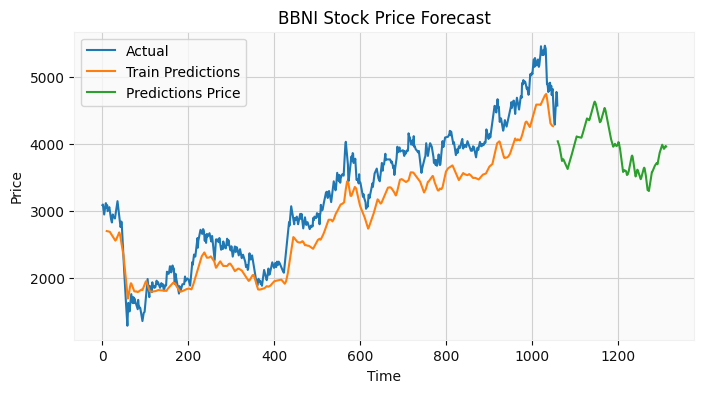

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(prices[:train_size + lookback], label='Actual')
plt.plot(range(lookback, train_size), train_preds, label='Train Predictions')
plt.plot(range(train_size + lookback, len(prices)), test_preds, label='Predictions Price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("BBNI Stock Price Forecast")
plt.legend()
plt.show()

In [38]:
# Mengambil periode yang sesuai untuk Test Predictions dan Actual
test_actual = prices[train_size + lookback:]

# Membuat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({'Harga Actual': test_actual.flatten(),
                              'Harga Prediksi': test_preds.flatten()})
#menampilkan dataframe perbandingan
comparison_df


,Harga Actual,Harga Prediksi
0,4377.856445,4038.224121
1,4368.678223,4025.550781
2,4286.077148,4008.045654
3,4322.789062,3981.563232
4,4157.586914,3960.116699
...,...,...
248,4540.000000,3932.444824
249,4540.000000,3944.916016
250,4540.000000,3956.726807
251,4400.000000,3968.454102


In [42]:
comparison_df.describe()

,Harga Actual,Harga Prediksi
count,253.000000,253.000000
mean,4432.732724,3930.834473
std,410.516151,336.419373
min,3414.177246,3297.867920
25%,4111.697266,3635.274658
50%,4387.034180,3926.222900
75%,4680.727051,4143.693359
max,5346.124512,4628.450195


In [43]:
import joblib
joblib.dump(scaler, 'scaler_lstm.save')
model.save('model_lstm.h5')